欢迎！

我们将了解 2018 Kaggle Data Science Bowl 机器学习竞赛。在这个竞赛中，我们会利用CNN对图像中的细胞进行图像分割。以下是今天会覆盖到的技术内容：<br>

1. EDA
2. Evaluation Metrics (评估指标)
3. Preprocessing (预处理)
4. U-Net (模型)
5. Transfer Learning (迁移学习)<br>
    ResNet50 pretrained on ImageNet

我们将用[Keras](https://keras.io/)来做数据预处理，建立模型和运算。Keras是建立在TF/Theano上的深度学习架构，将在TF 2.0中深度整合到TF中。<br>
在Keras中，我们可以自定义[预处理方式](https://keras.io/preprocessing/image/)，评估指标，层，等等的概念。这将有助于我们针对问题建立有效的解决方案<br>
[U-Net](https://arxiv.org/abs/1505.04597)是一个特别的FCN架构，他适合在数据量少、分类类别少的情况下建立图像分割的模型。由于他特殊的架构，我们无法使用简洁的Keras Sequential API来快速建立模型。我们会介绍如何用Keras建立计算图，并且在Keras中使用迁移学习。<br>

## Preprocessing


In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

train_path = './stage1_train/'
test_path = './stage1_test/'

In [2]:
train_id = next(os.walk(train_path))[1]
test_id = next(os.walk(test_path))[1]
input_H = 256
input_W = 256
channel = 3
output_H = input_H
output_W = input_W

In [3]:
def img_loader():
    if 'stage1_data_256_256.h5' not in os.listdir('./stage1_train'):
        # Retriving training samples, mask and reshape them to an uniform shape
        X_train = np.empty((len(train_id), input_H, input_W, channel), dtype = np.uint8)
        y_train = np.empty((len(train_id), output_H, output_W, 1), dtype = np.bool)
        for n, id in tqdm(enumerate(train_id), total = len(train_id)):
            path = train_path + id
            image = imread(path + '/images/' + id + '.png')[:,:,:channel]
            image = resize(image, (input_H, input_W), mode = 'constant', preserve_range = True)
            X_train[n] = image
            mask = np.zeros((output_H, output_W, 1))
            for mask_file in next(os.walk(path + '/masks/'))[2]:
                mask_ = imread(path + '/masks/' + mask_file)
                mask_ = resize(mask_, (output_H, output_W), mode = 'constant', preserve_range = True)
                mask = np.maximum(np.expand_dims(mask_, axis = -1), mask)
            y_train[n] = mask

        X_test = np.empty((len(test_id), input_H, input_W, channel), dtype = np.uint8)
        for n, id in tqdm(enumerate(test_id), total = len(test_id)):
            path = test_path + id
            image = imread(path + '/images/' + id + '.png')[:,:,:channel]
            image = resize(image, (input_H, input_W), mode = 'constant', preserve_range = True)
            X_test[n] = image

        h5f =h5py.File('./stage1_train/stage1_data_256_256.h5', 'w')
        h5f.create_dataset('train_X', data = X_train)
        h5f.create_dataset('train_y', data = y_train)
        h5f.create_dataset('test_X', data = X_test)
        h5f.close()

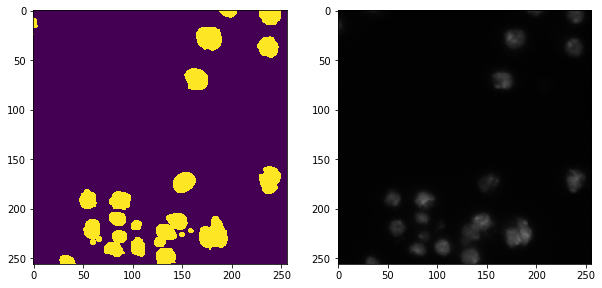

In [69]:
img_loader()
data_h5 = h5py.File('./stage1_train/stage1_data_256_256.h5', 'r')
X_train = data_h5['train_X'][:]
y_train = data_h5['train_y'][:]
X_test  = data_h5['test_X'][:]

#Look at the first image and mask.
f, ax = plt.subplots(1, 2, figsize = (10,10))
ax[0].imshow(np.squeeze(y_train[0]))
ax[1].imshow(X_train[0])

### Define the mean IOU function at different threshold.
This function will be used to evaluate accuracy at different threshold.

In [5]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        mIOU, conf_mat = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([conf_mat]):
            mIOU = tf.identity(mIOU)
        prec.append(mIOU)
    return K.mean(K.stack(prec), axis = 0)

### Define U-Net architecture
![](U-Net_Architecture.png)

In [6]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Cropping2D, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, SeparableConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf

Using TensorFlow backend.


In [7]:
#Building the U-Net
inputs = Input((input_H, input_W, channel))
s = Lambda(lambda x: x/255)(inputs)

c1 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(s)
c1 = BatchNormalization()(c1)
c1 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(p1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(p2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(p3)
c4 = BatchNormalization()(c4)
c4 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c4)
# drop4 = Dropout(0.5)(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(1024, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(p4)
c5 = BatchNormalization()(c5)
c5 = Conv2D(1024, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c5)
u5 = UpSampling2D()(c5)
u5 = Conv2D(512, (2, 2), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(u5)

c6 = concatenate([c4, u5])
c6 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c6)
c6 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c6)
u6 = UpSampling2D()(c6)
u6 = Conv2D(256, 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(u6)

c7 = concatenate([c3, u6])
c7 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c7)
c7 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c7)
u7 = UpSampling2D()(c7)
u7 = Conv2D(128, 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(u7)

c8 = concatenate([c2, u7])
c8 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c8)
c8 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c8)
u8 = UpSampling2D()(c8)
u8 = Conv2D(64, 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(u8)

c9 = concatenate([c1, u8])
c9 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c9)
c9 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c9)

outputs = Conv2D(1, 1, activation = 'sigmoid')(c9)

model_UC = Model(inputs = [inputs], outputs = [outputs])
model_UC.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = [mean_iou])
model_UC.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

concatenate_4 (Concatenate)     (None, 256, 256, 128 0           conv2d_2[0][0]                   
                                                                 conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 64) 73792       concatenate_4[0][0]              
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 1)  65          conv2d_22[0][0]                  
Total params: 31,039,681
Trainable params: 31,035,713
Non-trainable params: 3,968
__________________________________________________________________________________________________


In [8]:
plot_model(model_UC, to_file='basic_model.png')

In [9]:
rOp = ReduceLROnPlateau(factor = 0.5, patience = 3)
earlystopper = EarlyStopping(patience = 10, verbose = 2)
results = model_UC.fit(X_train, y_train, validation_split = 0.1, batch_size = 8, epochs = 100, callbacks = [rOp, earlystopper], verbose = 2)
model_UC.save('./models/U-Net_UC_basic.h5')

Train on 603 samples, validate on 67 samples
Epoch 1/100
 - 70s - loss: 0.2754 - mean_iou: 0.5473 - val_loss: 0.1335 - val_mean_iou: 0.6372
Epoch 2/100
 - 67s - loss: 0.1275 - mean_iou: 0.6832 - val_loss: 0.1934 - val_mean_iou: 0.7136
Epoch 3/100
 - 67s - loss: 0.1117 - mean_iou: 0.7309 - val_loss: 0.1183 - val_mean_iou: 0.7436
Epoch 4/100
 - 67s - loss: 0.1030 - mean_iou: 0.7521 - val_loss: 0.1216 - val_mean_iou: 0.7610
Epoch 5/100
 - 66s - loss: 0.0824 - mean_iou: 0.7690 - val_loss: 0.1568 - val_mean_iou: 0.7765
Epoch 6/100
 - 66s - loss: 0.0812 - mean_iou: 0.7810 - val_loss: 0.0910 - val_mean_iou: 0.7873
Epoch 7/100
 - 66s - loss: 0.0799 - mean_iou: 0.7921 - val_loss: 0.0808 - val_mean_iou: 0.7961
Epoch 8/100
 - 66s - loss: 0.0819 - mean_iou: 0.7999 - val_loss: 0.1151 - val_mean_iou: 0.8018
Epoch 9/100
 - 66s - loss: 0.1031 - mean_iou: 0.8024 - val_loss: 0.2207 - val_mean_iou: 0.8037
Epoch 10/100
 - 65s - loss: 0.0860 - mean_iou: 0.8053 - val_loss: 0.0830 - val_mean_iou: 0.8070
Epoc

In [11]:
#Building the U-Net, replace up-conv with tranpose convolution
inputs = Input((input_H, input_W, channel))
s = Lambda(lambda x: x/255)(inputs)

c1 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(s)
c1 = BatchNormalization()(c1)
c1 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(p1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(p2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(p3)
c4 = BatchNormalization()(c4)
c4 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c4)
# drop4 = Dropout(0.5)(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(1024, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(p4)
c5 = BatchNormalization()(c5)
c5 = Conv2D(1024, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c5)
u5 = Conv2DTranspose(512, 3, strides = (2, 2), padding = 'same', activation = 'relu')(c5)

c6 = concatenate([c4, u5])
c6 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c6)
c6 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c6)
u6 = Conv2DTranspose(256, 3, strides = (2, 2), padding = 'same', activation = 'relu')(c6)

c7 = concatenate([c3, u6])
c7 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c7)
c7 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c7)
u7 = Conv2DTranspose(512, 3, strides = (2, 2), padding = 'same', activation = 'relu')(c7)

c8 = concatenate([c2, u7])
c8 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c8)
c8 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c8)
u8 = Conv2DTranspose(512, 3, strides = (2, 2), padding = 'same', activation = 'relu')(c8)

c9 = concatenate([c1, u8])
c9 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c9)
c9 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c9)

outputs = Conv2D(1, 1, activation = 'sigmoid')(c9)

model_TC = Model(inputs = [inputs], outputs = [outputs])
model_TC.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = [mean_iou])
model_TC.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 64) 1792        lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 256, 256, 64) 256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 

Total params: 36,623,361
Trainable params: 36,619,393
Non-trainable params: 3,968
__________________________________________________________________________________________________


In [12]:
rOp = ReduceLROnPlateau(factor = 0.5, patience = 3)
earlystopper = EarlyStopping(patience = 10, verbose = 2)
results = model_TC.fit(X_train, y_train, validation_split = 0.1, batch_size = 4, epochs = 100, callbacks = [rOp, earlystopper], verbose = 2)
model_TC.save('./models/U-Net_TC_basic.h5')

Train on 603 samples, validate on 67 samples
Epoch 1/100
 - 119s - loss: 0.3169 - mean_iou: 0.4898 - val_loss: 0.3719 - val_mean_iou: 0.5837
Epoch 2/100
 - 114s - loss: 0.1458 - mean_iou: 0.6262 - val_loss: 0.1290 - val_mean_iou: 0.6596
Epoch 3/100
 - 113s - loss: 0.1226 - mean_iou: 0.6872 - val_loss: 0.2848 - val_mean_iou: 0.7058
Epoch 4/100
 - 113s - loss: 0.1152 - mean_iou: 0.7190 - val_loss: 0.3918 - val_mean_iou: 0.7248
Epoch 5/100
 - 112s - loss: 0.1036 - mean_iou: 0.7313 - val_loss: 0.0980 - val_mean_iou: 0.7391
Epoch 6/100
 - 112s - loss: 0.0849 - mean_iou: 0.7482 - val_loss: 0.0996 - val_mean_iou: 0.7549
Epoch 7/100
 - 112s - loss: 0.1017 - mean_iou: 0.7581 - val_loss: 0.1114 - val_mean_iou: 0.7623
Epoch 8/100
 - 112s - loss: 0.0846 - mean_iou: 0.7679 - val_loss: 0.0884 - val_mean_iou: 0.7724
Epoch 9/100
 - 112s - loss: 0.0750 - mean_iou: 0.7772 - val_loss: 0.0797 - val_mean_iou: 0.7815
Epoch 10/100
 - 112s - loss: 0.0826 - mean_iou: 0.7844 - val_loss: 0.1004 - val_mean_iou: 0

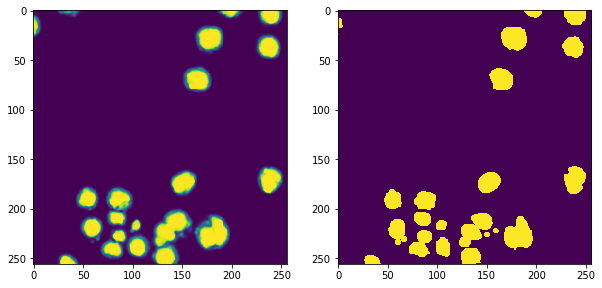

In [13]:
# sanity check
y_pred = np.squeeze(model_UC.predict(np.expand_dims(X_train[0], 0)))
y_true = np.squeeze(y_train[0])
f, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(y_pred)
ax[1].imshow(y_true)

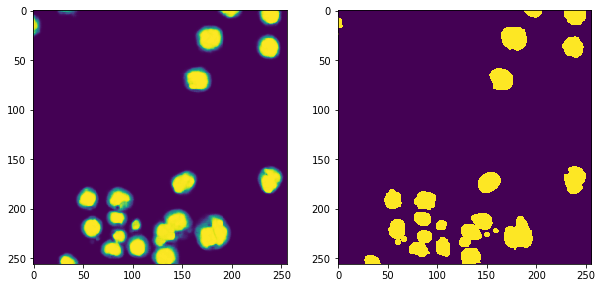

In [14]:
y_pred = np.squeeze(model_TC.predict(np.expand_dims(X_train[0], 0)))
y_true = np.squeeze(y_train[0])
f, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(y_pred)
ax[1].imshow(y_true)

In [15]:
inputs = Input((input_H, input_W, channel))
c = Lambda(lambda x: x/255)(inputs)

def encoder(input_, n_filters):
    c = Conv2D(n_filters, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(input_)
    c = BatchNormalization()(c)
    c = Conv2D(n_filters, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c)
    p = MaxPooling2D((2, 2))(c)
    return p, c

def decoder(input_, n_filters, skip_connection = None):
    out_filters = int(n_filters / 2)
    if skip_connection is None:
        c = input_
    else:
        c = concatenate([skip_connection, input_])
    c = Conv2D(n_filters, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c)
    c = Conv2D(n_filters, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(c)
    u = UpSampling2D()(c)
    u = Conv2D(out_filters, 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(u)
    return u
        
skip_connections = []
encoder_filters = [64, 128, 256, 512]
decoder_filters = [1024, 512, 256, 128]
# construct U_Net
for i in encoder_filters:
    c, p = encoder(c, i)
    skip_connections.append(p)
    
skip_connections += [None]
skip_connections = list(reversed(skip_connections))

for i, j in zip(skip_connections, decoder_filters):
    c = decoder(c, j, i)
    
outputs = Conv2D(1, 1, activation = 'sigmoid')(c)

model_CP = Model(inputs = [inputs], outputs = [outputs])
model_CP.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = [mean_iou])
model_CP.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 256, 64) 1792        lambda_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 256, 256, 64) 256         conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 

Non-trainable params: 1,920
__________________________________________________________________________________________________


In [16]:
plot_model(model_CP, to_file='basic_model_CP.png')

In [17]:
from keras.applications.resnet50 import ResNet50,preprocess_input

In [18]:
R50 = ResNet50(include_top = False, input_shape = (input_H, input_W, 3))
R50.layers.pop()
# for layer in R50.layers:
#     layer.trainable = False
    
# Layers from ResNet50 to make skip connections
skip_ix = [172, 140, 78, 36, 3]
# Layers in decoder to connect to encoder
skip_end = []
for i in skip_ix:
    skip_end.append(R50.layers[i])

In [19]:
# Use billinear additive upsampling (BAU) and separable convolution to reduce the total amount of hyperparameters
def BAU_layer(last_layer, channel_num):
    additive = []
    depth = int(last_layer.get_shape()[-1])
    step = int(depth / channel_num)
    last_layer[:, :, :, 1*step:(1*step+step)]
    for i in range(channel_num):
        layersum = K.mean(last_layer[:, :, :, i*step:(i*step+step)], axis = -1)
        additive.append(layersum)
    additive = K.stack(additive, axis = -1)
    return additive

def upsampling_step(skipped_conv, num_output_filters, prev_conv = None):
    num_filters = skipped_conv.output_shape[-1]
    if prev_conv != None:
        concat_layer = concatenate([skipped_conv.output, prev_conv])
    else:
        concat_layer = skipped_conv.output
    conv1 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(concat_layer)
    conv2 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(conv1)
    up = UpSampling2D()(conv2)
    if num_filters != up.get_shape()[-1]:
        BAU = Lambda(BAU_layer, arguments = {'channel_num': num_output_filters})(up)
        conv3 = SeparableConv2D(num_output_filters, 2, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(BAU)
    else:
        conv3 = SeparableConv2D(num_output_filters, 2, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(up)
    return conv3

up_num_filters = [1024, 512, 256, 64, 64]
for n, i in enumerate(up_num_filters):
    if n == 0:
        conv_layer = upsampling_step(skip_end[n], i)
    else:
        conv_layer = upsampling_step(skip_end[n], i, conv_layer)

out = conv3 = Conv2D(1, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal')(conv_layer)
model_R50 = Model(inputs = R50.inputs, outputs = [out])
model_R50.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = [mean_iou])
model_R50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

bn3a_branch2a (BatchNormalizati (None, 32, 32, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 32, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 32, 32, 128)  147584      activation_11[0][0]              
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 32, 32, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 32, 32, 128)  0           bn3a_branch2b[0][0]              
__________________________________________________________________________________________________
res3a_bran

                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 32, 32, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 16, 16, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 16, 16, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 16, 16, 256)  0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_bran

__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 16, 16, 1024) 263168      activation_33[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 16, 16, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_11 (Add)                    (None, 16, 16, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_31[0][0]              
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 16, 16, 1024) 0           add_11[0][0]                     
__________________________________________________________________________________________________
res4e_bran

__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 8, 8, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 8, 8, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 8, 8, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 8, 8, 2048)   1050624     activation_45[0][0]              
__________________________________________________________________________________________________
bn5b_branch2c (BatchNormalizati (None, 8, 8, 2048)   8192        res5b_branch2c[0][0]             
__________

__________________________________________________________________________________________________
separable_conv2d_14 (SeparableC (None, 128, 128, 64) 4736        separable_conv2d_13[0][0]        
__________________________________________________________________________________________________
up_sampling2d_13 (UpSampling2D) (None, 256, 256, 64) 0           separable_conv2d_14[0][0]        
__________________________________________________________________________________________________
separable_conv2d_15 (SeparableC (None, 256, 256, 64) 4416        up_sampling2d_13[0][0]           
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 256, 256, 1)  65          separable_conv2d_15[0][0]        
Total params: 39,002,753
Trainable params: 38,949,633
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [20]:
plot_model(model_R50, to_file = 'ResNet50_modified.png', show_layer_names = True, show_shapes = True)

In [21]:
X_train_prep = preprocess_input(X_train.astype(np.float32))
rOp = ReduceLROnPlateau(factor = 0.5, patience = 3)
earlystopper = EarlyStopping(patience = 10, verbose = 2)
results = model_R50.fit(X_train_prep, y_train, validation_split = 0.1, batch_size = 4, epochs = 100, callbacks = [rOp, earlystopper], verbose = 2)
model_R50.save('./models/U-Net_R50.h5')

Train on 603 samples, validate on 67 samples
Epoch 1/100
 - 79s - loss: 0.3489 - mean_iou: 0.4344 - val_loss: 0.3120 - val_mean_iou: 0.4992
Epoch 2/100
 - 69s - loss: 0.1507 - mean_iou: 0.5589 - val_loss: 0.3925 - val_mean_iou: 0.6019
Epoch 3/100
 - 68s - loss: 0.1124 - mean_iou: 0.6306 - val_loss: 0.1364 - val_mean_iou: 0.6565
Epoch 4/100
 - 68s - loss: 0.1140 - mean_iou: 0.6748 - val_loss: 0.2617 - val_mean_iou: 0.6861
Epoch 5/100
 - 68s - loss: 0.0928 - mean_iou: 0.6979 - val_loss: 0.1408 - val_mean_iou: 0.7098
Epoch 6/100
 - 69s - loss: 0.0918 - mean_iou: 0.7194 - val_loss: 0.1732 - val_mean_iou: 0.7278
Epoch 7/100
 - 68s - loss: 0.0774 - mean_iou: 0.7365 - val_loss: 0.0873 - val_mean_iou: 0.7444
Epoch 8/100
 - 69s - loss: 0.0775 - mean_iou: 0.7510 - val_loss: 0.0832 - val_mean_iou: 0.7569
Epoch 9/100
 - 68s - loss: 0.0751 - mean_iou: 0.7621 - val_loss: 0.0860 - val_mean_iou: 0.7671
Epoch 10/100
 - 68s - loss: 0.0729 - mean_iou: 0.7714 - val_loss: 0.0807 - val_mean_iou: 0.7757
Epoc

In [22]:
from keras.preprocessing.image import ImageDataGenerator

In [23]:
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = False, featurewise_std_normalization = False,
                             samplewise_std_normalization = False,
                            rotation_range = 90,
                            width_shift_range =0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.1,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            fill_mode = 'reflect')

In [73]:
n_iter = 30
batch_size = 67
X_aug = np.zeros((n_iter * batch_size, input_H, input_W, 3), dtype = np.uint8)
y_aug = np.zeros((n_iter * batch_size, input_H, input_W, 1), dtype = np.uint8)
X_gen = datagen.flow(X_train, batch_size = batch_size, seed = 1024)
y_gen = datagen.flow(y_train, batch_size = batch_size, seed = 1024)
for i in range(0, n_iter * batch_size, batch_size):
    X_aug[i : i + batch_size] = next(X_gen)
    y_aug[i : i + batch_size] = next(y_gen)

In [28]:
model_UC.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = [mean_iou])

rOp = ReduceLROnPlateau(factor = 0.5, patience = 3)
earlystopper = EarlyStopping(patience = 10, verbose = 2)
results = model_UC.fit(X_aug, y_aug, validation_split = 0.1, batch_size = 8, epochs = 100, callbacks = [rOp, earlystopper], verbose = 2)
model_UC.save('./models/U-Net_UC_basic_IA.h5')

Train on 1809 samples, validate on 201 samples
Epoch 1/100
 - 195s - loss: 0.0776 - mean_iou: 0.8389 - val_loss: 0.0754 - val_mean_iou: 0.8421
Epoch 2/100
 - 197s - loss: 0.0701 - mean_iou: 0.8447 - val_loss: 0.0797 - val_mean_iou: 0.8466
Epoch 3/100
 - 195s - loss: 0.0677 - mean_iou: 0.8488 - val_loss: 0.0712 - val_mean_iou: 0.8497
Epoch 4/100
 - 194s - loss: 0.0649 - mean_iou: 0.8510 - val_loss: 0.0719 - val_mean_iou: 0.8511
Epoch 5/100
 - 193s - loss: 0.0647 - mean_iou: 0.8511 - val_loss: 0.0680 - val_mean_iou: 0.8520
Epoch 6/100
 - 192s - loss: 0.0644 - mean_iou: 0.8529 - val_loss: 0.0743 - val_mean_iou: 0.8535
Epoch 7/100
 - 192s - loss: 0.0659 - mean_iou: 0.8533 - val_loss: 0.0738 - val_mean_iou: 0.8537
Epoch 8/100
 - 192s - loss: 0.0658 - mean_iou: 0.8540 - val_loss: 0.0737 - val_mean_iou: 0.8545
Epoch 9/100
 - 193s - loss: 0.0618 - mean_iou: 0.8549 - val_loss: 0.0662 - val_mean_iou: 0.8557
Epoch 10/100
 - 193s - loss: 0.0607 - mean_iou: 0.8563 - val_loss: 0.0670 - val_mean_iou:

In [29]:
model_TC.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = [mean_iou])

rOp = ReduceLROnPlateau(factor = 0.5, patience = 3)
earlystopper = EarlyStopping(patience = 10, verbose = 2)
results = model_TC.fit(X_aug, y_aug, validation_split = 0.1, batch_size = 4, epochs = 100, callbacks = [rOp, earlystopper], verbose = 2)
model_TC.save('./models/U-Net_TC_basic_IA.h5')

Train on 1809 samples, validate on 201 samples
Epoch 1/100
 - 345s - loss: 0.0757 - mean_iou: 0.8422 - val_loss: 0.0927 - val_mean_iou: 0.8412
Epoch 2/100
 - 336s - loss: 0.0725 - mean_iou: 0.8427 - val_loss: 0.0957 - val_mean_iou: 0.8443
Epoch 3/100
 - 335s - loss: 0.0692 - mean_iou: 0.8454 - val_loss: 0.0797 - val_mean_iou: 0.8466
Epoch 4/100
 - 335s - loss: 0.0663 - mean_iou: 0.8479 - val_loss: 0.1312 - val_mean_iou: 0.8478
Epoch 5/100
 - 334s - loss: 0.0673 - mean_iou: 0.8474 - val_loss: 0.1301 - val_mean_iou: 0.8478
Epoch 6/100
 - 334s - loss: 0.0744 - mean_iou: 0.8472 - val_loss: 0.0868 - val_mean_iou: 0.8473
Epoch 7/100
 - 334s - loss: 0.0642 - mean_iou: 0.8483 - val_loss: 0.0676 - val_mean_iou: 0.8492
Epoch 8/100
 - 334s - loss: 0.0623 - mean_iou: 0.8501 - val_loss: 0.0699 - val_mean_iou: 0.8509
Epoch 9/100
 - 335s - loss: 0.0622 - mean_iou: 0.8517 - val_loss: 0.0673 - val_mean_iou: 0.8523
Epoch 10/100
 - 335s - loss: 0.0607 - mean_iou: 0.8530 - val_loss: 0.0694 - val_mean_iou:

In [75]:
model_R50.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = [mean_iou])

X_train_prep = preprocess_input(X_aug.astype(np.float32))
rOp = ReduceLROnPlateau(factor = 0.5, patience = 3)
earlystopper = EarlyStopping(patience = 10, verbose = 2)
results = model_R50.fit(X_train_prep, y_aug, validation_split = 0.1, batch_size = 4, epochs = 100, callbacks = [rOp], verbose = 2)
model_R50.save('./models/U-Net_R50.h5')

Train on 1809 samples, validate on 201 samples
Epoch 1/100
 - 223s - loss: 0.0634 - mean_iou: 0.8619 - val_loss: 0.1175 - val_mean_iou: 0.8582
Epoch 2/100
 - 208s - loss: 0.0606 - mean_iou: 0.8568 - val_loss: 0.0974 - val_mean_iou: 0.8604
Epoch 3/100
 - 207s - loss: 0.0600 - mean_iou: 0.8621 - val_loss: 0.1759 - val_mean_iou: 0.8610
Epoch 4/100
 - 208s - loss: 0.0600 - mean_iou: 0.8600 - val_loss: 0.1242 - val_mean_iou: 0.8596
Epoch 5/100
 - 209s - loss: 0.0600 - mean_iou: 0.8591 - val_loss: 0.1366 - val_mean_iou: 0.8582
Epoch 6/100
 - 208s - loss: 0.0574 - mean_iou: 0.8577 - val_loss: 0.0805 - val_mean_iou: 0.8586
Epoch 7/100
 - 209s - loss: 0.0566 - mean_iou: 0.8594 - val_loss: 0.0953 - val_mean_iou: 0.8602
Epoch 8/100
 - 208s - loss: 0.0560 - mean_iou: 0.8607 - val_loss: 0.0935 - val_mean_iou: 0.8610
Epoch 9/100
 - 208s - loss: 0.0558 - mean_iou: 0.8613 - val_loss: 0.0764 - val_mean_iou: 0.8619
Epoch 10/100
 - 208s - loss: 0.0556 - mean_iou: 0.8625 - val_loss: 0.0936 - val_mean_iou:

Epoch 85/100
 - 208s - loss: 0.0514 - mean_iou: 0.8776 - val_loss: 0.0899 - val_mean_iou: 0.8776
Epoch 86/100
 - 208s - loss: 0.0512 - mean_iou: 0.8777 - val_loss: 0.0911 - val_mean_iou: 0.8777
Epoch 87/100
 - 208s - loss: 0.0513 - mean_iou: 0.8777 - val_loss: 0.0914 - val_mean_iou: 0.8777
Epoch 88/100
 - 208s - loss: 0.0513 - mean_iou: 0.8777 - val_loss: 0.0878 - val_mean_iou: 0.8777
Epoch 89/100
 - 207s - loss: 0.0510 - mean_iou: 0.8778 - val_loss: 0.0889 - val_mean_iou: 0.8778
Epoch 90/100
 - 208s - loss: 0.0513 - mean_iou: 0.8778 - val_loss: 0.0915 - val_mean_iou: 0.8778
Epoch 91/100
 - 208s - loss: 0.0514 - mean_iou: 0.8778 - val_loss: 0.0912 - val_mean_iou: 0.8778
Epoch 92/100
 - 208s - loss: 0.0514 - mean_iou: 0.8779 - val_loss: 0.0876 - val_mean_iou: 0.8779
Epoch 93/100
 - 208s - loss: 0.0513 - mean_iou: 0.8779 - val_loss: 0.0901 - val_mean_iou: 0.8779
Epoch 94/100
 - 207s - loss: 0.0512 - mean_iou: 0.8779 - val_loss: 0.0912 - val_mean_iou: 0.8779
Epoch 95/100
 - 208s - loss: 0

In [31]:
# resnet without pretrain
R50 = ResNet50(weights = None, include_top = False, input_shape = (input_H, input_W, 3))
R50.layers.pop()
# for layer in R50.layers:
#     layer.trainable = False
    
# Layers from ResNet50 to make skip connections
skip_ix = [172, 140, 78, 36, 3]
# Layers in decoder to connect to encoder
skip_end = []
for i in skip_ix:
    skip_end.append(R50.layers[i])
    
# Use billinear additive upsampling (BAU) and separable convolution to reduce the total amount of hyperparameters
def BAU_layer(last_layer, channel_num):
    additive = []
    depth = int(last_layer.get_shape()[-1])
    step = int(depth / channel_num)
    last_layer[:, :, :, 1*step:(1*step+step)]
    for i in range(channel_num):
        layersum = K.mean(last_layer[:, :, :, i*step:(i*step+step)], axis = -1)
        additive.append(layersum)
    additive = K.stack(additive, axis = -1)
    return additive

def upsampling_step(skipped_conv, num_output_filters, prev_conv = None):
    num_filters = skipped_conv.output_shape[-1]
    if prev_conv != None:
        concat_layer = concatenate([skipped_conv.output, prev_conv])
    else:
        concat_layer = skipped_conv.output
    conv1 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(concat_layer)
    conv2 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(conv1)
    up = UpSampling2D()(conv2)
    if num_filters != up.get_shape()[-1]:
        BAU = Lambda(BAU_layer, arguments = {'channel_num': num_output_filters})(up)
        conv3 = SeparableConv2D(num_output_filters, 2, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(BAU)
    else:
        conv3 = SeparableConv2D(num_output_filters, 2, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(up)
    return conv3

up_num_filters = [1024, 512, 256, 64, 64]
for n, i in enumerate(up_num_filters):
    if n == 0:
        conv_layer = upsampling_step(skip_end[n], i)
    else:
        conv_layer = upsampling_step(skip_end[n], i, conv_layer)

out = conv3 = Conv2D(1, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal')(conv_layer)
model_R50_no_pt = Model(inputs = R50.inputs, outputs = [out])
model_R50_no_pt.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = [mean_iou])
model_R50_no_pt.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 128, 128, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

bn3a_branch2a (BatchNormalizati (None, 32, 32, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 32, 32, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 32, 32, 128)  147584      activation_60[0][0]              
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 32, 32, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 32, 32, 128)  0           bn3a_branch2b[0][0]              
__________________________________________________________________________________________________
res3a_bran

                                                                 activation_68[0][0]              
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 32, 32, 512)  0           add_23[0][0]                     
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 16, 16, 256)  131328      activation_71[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 16, 16, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 16, 16, 256)  0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_bran

__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 16, 16, 1024) 263168      activation_82[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 16, 16, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_27 (Add)                    (None, 16, 16, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
activation_83 (Activation)      (None, 16, 16, 1024) 0           add_27[0][0]                     
__________________________________________________________________________________________________
res4e_bran

__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 8, 8, 512)    2359808     activation_93[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 8, 8, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 8, 8, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 8, 8, 2048)   1050624     activation_94[0][0]              
__________________________________________________________________________________________________
bn5b_branch2c (BatchNormalizati (None, 8, 8, 2048)   8192        res5b_branch2c[0][0]             
__________

__________________________________________________________________________________________________
separable_conv2d_29 (SeparableC (None, 128, 128, 64) 4736        separable_conv2d_28[0][0]        
__________________________________________________________________________________________________
up_sampling2d_18 (UpSampling2D) (None, 256, 256, 64) 0           separable_conv2d_29[0][0]        
__________________________________________________________________________________________________
separable_conv2d_30 (SeparableC (None, 256, 256, 64) 4416        up_sampling2d_18[0][0]           
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 256, 256, 1)  65          separable_conv2d_30[0][0]        
Total params: 39,002,753
Trainable params: 38,949,633
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [76]:
model_R50_no_pt.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [mean_iou])

X_train_prep = preprocess_input(X_aug.astype(np.float32))
rOp = ReduceLROnPlateau(factor = 0.5, patience = 3)
earlystopper = EarlyStopping(patience = 10, verbose = 2)
results = model_R50_no_pt.fit(X_train_prep, y_aug, validation_split = 0.1, batch_size = 4, epochs = 100, callbacks = [rOp], verbose = 2)
model_R50_no_pt.save('./models/U-Net_R50_no_pt.h5')

Train on 1809 samples, validate on 201 samples
Epoch 1/100
 - 226s - loss: 0.4088 - mean_iou: 0.4335 - val_loss: 0.4956 - val_mean_iou: 0.4410
Epoch 2/100
 - 210s - loss: 0.1426 - mean_iou: 0.4871 - val_loss: 0.1972 - val_mean_iou: 0.5395
Epoch 3/100
 - 210s - loss: 0.1082 - mean_iou: 0.5791 - val_loss: 0.1979 - val_mean_iou: 0.6137
Epoch 4/100
 - 209s - loss: 0.0955 - mean_iou: 0.6379 - val_loss: 0.4603 - val_mean_iou: 0.6554
Epoch 5/100
 - 210s - loss: 0.0914 - mean_iou: 0.6678 - val_loss: 0.1212 - val_mean_iou: 0.6815
Epoch 6/100
 - 210s - loss: 0.0872 - mean_iou: 0.6926 - val_loss: 0.1327 - val_mean_iou: 0.7030
Epoch 7/100
 - 209s - loss: 0.0828 - mean_iou: 0.7116 - val_loss: 0.1167 - val_mean_iou: 0.7190
Epoch 8/100
 - 208s - loss: 0.0813 - mean_iou: 0.7252 - val_loss: 0.2202 - val_mean_iou: 0.7306
Epoch 9/100
 - 210s - loss: 0.0801 - mean_iou: 0.7353 - val_loss: 0.1432 - val_mean_iou: 0.7397
Epoch 10/100
 - 210s - loss: 0.0796 - mean_iou: 0.7436 - val_loss: 0.1323 - val_mean_iou:

Epoch 85/100
 - 210s - loss: 0.0632 - mean_iou: 0.8403 - val_loss: 0.0848 - val_mean_iou: 0.8404
Epoch 86/100
 - 210s - loss: 0.0633 - mean_iou: 0.8405 - val_loss: 0.0854 - val_mean_iou: 0.8406
Epoch 87/100
 - 210s - loss: 0.0637 - mean_iou: 0.8407 - val_loss: 0.0846 - val_mean_iou: 0.8407
Epoch 88/100
 - 210s - loss: 0.0633 - mean_iou: 0.8408 - val_loss: 0.0845 - val_mean_iou: 0.8409
Epoch 89/100
 - 210s - loss: 0.0632 - mean_iou: 0.8410 - val_loss: 0.0854 - val_mean_iou: 0.8411
Epoch 90/100
 - 210s - loss: 0.0631 - mean_iou: 0.8412 - val_loss: 0.0835 - val_mean_iou: 0.8412
Epoch 91/100
 - 211s - loss: 0.0631 - mean_iou: 0.8413 - val_loss: 0.0839 - val_mean_iou: 0.8414
Epoch 92/100
 - 210s - loss: 0.0631 - mean_iou: 0.8415 - val_loss: 0.0831 - val_mean_iou: 0.8416
Epoch 93/100
 - 211s - loss: 0.0636 - mean_iou: 0.8416 - val_loss: 0.0821 - val_mean_iou: 0.8417
Epoch 94/100
 - 210s - loss: 0.0642 - mean_iou: 0.8418 - val_loss: 0.0847 - val_mean_iou: 0.8419
Epoch 95/100
 - 210s - loss: 0

In [33]:
import gc
from utils import *

In [36]:
try:
    del X_train, y_train, X_aug, y_aug
except:
    pass
gc.collect()

X_train = np.empty((len(train_id), input_H, input_W, channel), dtype = np.uint8)
y_train_mask = np.empty((len(train_id), output_H, output_W, 1), dtype = np.bool)
y_train_edge = np.empty((len(train_id), output_H, output_W, 1), dtype = np.bool)
for n, id in tqdm(enumerate(train_id), total = len(train_id)):
    path = train_path + id
    image = imread(path + '/images/' + id + '.png')[:,:,:channel]
    image = resize(image, (input_H, input_W), mode = 'constant', preserve_range = True)
    X_train[n] = image
    mask = np.zeros((output_H, output_W, 1))
    y = []
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = resize(mask_, (output_H, output_W), mode = 'constant', preserve_range = True)
        y.append(np.expand_dims(mask_, -1))
    y_train_mask[n], y_train_edge[n] = label_prep(y)    

X_test = np.empty((len(test_id), input_H, input_W, channel), dtype = np.uint8)
for n, id in tqdm(enumerate(test_id), total = len(test_id)):
    path = test_path + id
    image = imread(path + '/images/' + id + '.png')[:,:,:channel]
    image = resize(image, (input_H, input_W), mode = 'constant', preserve_range = True)
    X_test[n] = image

100%|████████████████████████████████████| 65/65 [00:01<00:00, 38.85it/s]


In [41]:
def U_Net_multi_target():
    inputs = Input((input_H, input_W, channel))
    c = Lambda(lambda x: x/255)(inputs)
    skip_connections = []
    encoder_filters = [64, 128, 256, 512]
    decoder_filters = [1024, 512, 256, 128]
    # construct U_Net
    for i in encoder_filters:
        c, p = encoder(c, i)
        skip_connections.append(p)

    skip_connections += [None]
    skip_connections = list(reversed(skip_connections))

    for i, j in zip(skip_connections, decoder_filters):
        c = decoder(c, j, i)
        
    output_mask = Conv2D(1, 1, activation = 'sigmoid', name = 'output_mask')(c)
    output_edge = Conv2D(1, 1, activation = 'sigmoid', name = 'output_edge')(c)
    model = Model(inputs = inputs, outputs = [output_mask, output_edge])
    model.compile(optimizer = Adam(lr = 1e-3), loss = {'output_mask': 'binary_crossentropy', 'output_edge': 'binary_crossentropy'})
    return model

In [42]:
new_model = U_Net_multi_target()

In [44]:
plot_model(new_model, 'new_model.png', show_layer_names = True)

In [50]:
new_model = U_Net_multi_target()
rOp = ReduceLROnPlateau(factor = 0.5, patience = 3)
earlystopper = EarlyStopping(patience = 10, verbose = 2)
results = new_model.fit(X_train, [y_train_mask, y_train_edge], validation_split = 0.1, batch_size = 4, epochs = 100, verbose = 2)

Train on 603 samples, validate on 67 samples
Epoch 1/100
 - 68s - loss: 1.1445 - output_mask_loss: 0.8289 - output_edge_loss: 0.3156 - val_loss: 0.2795 - val_output_mask_loss: 0.1535 - val_output_edge_loss: 0.1261
Epoch 2/100
 - 64s - loss: 0.2659 - output_mask_loss: 0.1531 - output_edge_loss: 0.1128 - val_loss: 0.2801 - val_output_mask_loss: 0.1796 - val_output_edge_loss: 0.1005
Epoch 3/100
 - 65s - loss: 0.2152 - output_mask_loss: 0.1174 - output_edge_loss: 0.0978 - val_loss: 0.3045 - val_output_mask_loss: 0.1785 - val_output_edge_loss: 0.1260
Epoch 4/100
 - 65s - loss: 0.2069 - output_mask_loss: 0.1139 - output_edge_loss: 0.0930 - val_loss: 0.2048 - val_output_mask_loss: 0.1094 - val_output_edge_loss: 0.0954
Epoch 5/100
 - 65s - loss: 0.1978 - output_mask_loss: 0.1051 - output_edge_loss: 0.0927 - val_loss: 0.2030 - val_output_mask_loss: 0.1118 - val_output_edge_loss: 0.0911
Epoch 6/100
 - 64s - loss: 0.1679 - output_mask_loss: 0.0837 - output_edge_loss: 0.0842 - val_loss: 0.1706 - v

Epoch 49/100
 - 63s - loss: 0.1279 - output_mask_loss: 0.0598 - output_edge_loss: 0.0680 - val_loss: 0.1414 - val_output_mask_loss: 0.0711 - val_output_edge_loss: 0.0703
Epoch 50/100
 - 63s - loss: 0.1314 - output_mask_loss: 0.0623 - output_edge_loss: 0.0691 - val_loss: 0.1403 - val_output_mask_loss: 0.0698 - val_output_edge_loss: 0.0705
Epoch 51/100
 - 63s - loss: 0.1315 - output_mask_loss: 0.0625 - output_edge_loss: 0.0690 - val_loss: 0.1889 - val_output_mask_loss: 0.1129 - val_output_edge_loss: 0.0761
Epoch 52/100
 - 63s - loss: 0.1284 - output_mask_loss: 0.0599 - output_edge_loss: 0.0684 - val_loss: 0.1429 - val_output_mask_loss: 0.0725 - val_output_edge_loss: 0.0705
Epoch 53/100
 - 63s - loss: 0.1294 - output_mask_loss: 0.0609 - output_edge_loss: 0.0685 - val_loss: 0.1511 - val_output_mask_loss: 0.0761 - val_output_edge_loss: 0.0751
Epoch 54/100
 - 63s - loss: 0.1308 - output_mask_loss: 0.0618 - output_edge_loss: 0.0691 - val_loss: 0.1457 - val_output_mask_loss: 0.0757 - val_outpu

Epoch 98/100
 - 63s - loss: 0.1119 - output_mask_loss: 0.0498 - output_edge_loss: 0.0621 - val_loss: 0.1370 - val_output_mask_loss: 0.0672 - val_output_edge_loss: 0.0698
Epoch 99/100
 - 63s - loss: 0.1110 - output_mask_loss: 0.0493 - output_edge_loss: 0.0616 - val_loss: 0.1478 - val_output_mask_loss: 0.0770 - val_output_edge_loss: 0.0708
Epoch 100/100
 - 63s - loss: 0.1096 - output_mask_loss: 0.0484 - output_edge_loss: 0.0612 - val_loss: 0.1366 - val_output_mask_loss: 0.0667 - val_output_edge_loss: 0.0699


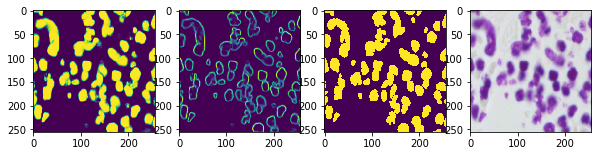

In [64]:
# sanity check
i = 34
y_mask, y_edge = new_model.predict(np.expand_dims(X_train[i], 0))
y_true = np.squeeze(y_train_mask[i])
f, ax = plt.subplots(1,4, figsize = (10, 10))
ax[0].imshow(np.squeeze(y_mask))
ax[1].imshow(np.squeeze(y_edge))
ax[2].imshow(y_true)
ax[3].imshow(np.squeeze(X_train[i]))
plt.show()

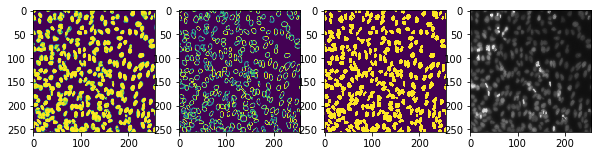

In [65]:
# sanity check
i = 21
y_mask, y_edge = new_model.predict(np.expand_dims(X_train[i], 0))
y_true = np.squeeze(y_train_mask[i])
f, ax = plt.subplots(1,4, figsize = (10, 10))
ax[0].imshow(np.squeeze(y_mask))
ax[1].imshow(np.squeeze(y_edge))
ax[2].imshow(y_true)
ax[3].imshow(np.squeeze(X_train[i]))
plt.show()

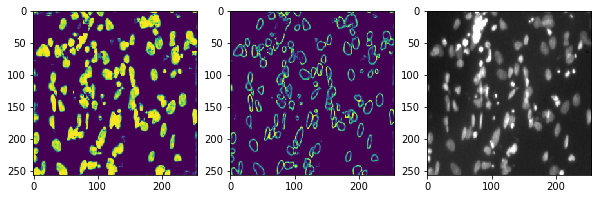

In [78]:
# sanity check
i = 21
y_mask, y_edge = new_model.predict(np.expand_dims(X_test[i], 0))
y_true = np.squeeze(y_train_mask[i])
f, ax = plt.subplots(1,3, figsize = (10, 10))
ax[0].imshow(np.squeeze(y_mask))
ax[1].imshow(np.squeeze(y_edge))
ax[2].imshow(np.squeeze(X_test[i]))
plt.show()